In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/finalhamza20.zip"

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pyplot

import numpy as np
import PIL

import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l1
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras import activations

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# -------

def set_trainable(model, flag=False):
    for layer in model.layers:
        layer.trainable = flag
        print("{0}:\t{1}".format(layer.trainable, layer.name))

def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

img_size = 224
# Network Architecture 
# Loading pretrained model
pre_model = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

80134624/80134624 [==============================] - 4s 0us/step


In [6]:
# Data augmentation and pre-processing

datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      # vertical_flip=True,
      fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)


# Directory setup



train_dir = '/content/finalplants/train'
test_dir = '/content/finalplants/test'

In [7]:
# input_shape = pre_model.layers[0].output_shape[1:3]
input_shape = (img_size, img_size)
batch_size = 70
batch_size_test = 60

num_of_test_samples = 3000

# Making data generator
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size_test,
                                                  shuffle=False)

# Setting epoch size for batch step calculation
epochs = 20

Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.


In [8]:
# Steps per epoch setup
steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

# joing directory and filenames
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

# classes available
cls_train = generator_train.classes
cls_test = generator_test.classes

class_names = list(generator_train.class_indices.keys())

num_classes = generator_train.num_classes

# In case of unequal number of dataset, use class weight balancing
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [9]:
# Architecture Definition

# Get last pool/conv layer of pre-trained model
last_conv_block = pre_model.get_layer('block5_pool') #VGG19
# last_conv_block = pre_model.get_layer('conv3_block2_1_relu') #DenseNet101

# setup a reference model which as input and conv layer output of pretrained model
ref_model = Model(inputs=pre_model.input, outputs=last_conv_block.output)

# create new model
transfer_model = keras.models.Sequential()
# add reference model to it
transfer_model.add(ref_model)
# flatten pretrained layers output for dense layer
transfer_model.add(Flatten())

# add custom hidden layer
# , activity_regularizer=l1(0.001)
transfer_model.add(Dense(1024, activation='relu'))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.5))

transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.5))

transfer_model.add(Dense(num_classes, activation='softmax'))

# setting learning rate
optimizer = SGD(learning_rate=0.001, momentum=0.9)#Adam(lr=1e-5)
# Loss definition
loss = 'categorical_crossentropy'
# Metrics for measurement
metrics = ['accuracy']

# for transfer learning set all the layers of pre-trained model to false
set_trainable(ref_model, flag=False)

# Compile the model
transfer_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
labels = generator_train.class_indices
print(labels)


checkpoint = ModelCheckpoint("transferc.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')



False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool
{'Aarons beard': 0, 'Anemone_coronaria': 1, 'Anemone_hepatica': 2, 'Anemone_hupehensis': 3, 'Anemone_nemorosa': 4, 'Anemone_ranunculoides': 5, 'Anthericum_liliago': 6, 'Barbarea_vulgaris': 7, 'Bee orchid': 8, 'Cirsium_eriophorum': 9, 'English lavender': 10, 'Field pumpkin': 11, 'Lactuca_perennis': 12, 'Male fern': 13, 'Small-leaf spiderwor': 14, 'Tutsan': 15, 'Virginia spiderwort': 16, 'daisy': 17, 'rose': 18, 'sunflower': 19}


In [10]:

# Begin training for transfer learning
history = transfer_model.fit(generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  # class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,callbacks=[checkpoint,early])

# Save Model weights
#transfer_model.save('transfer_18.model')
#transfer_model.save('./drive/My Drive/models/transfer_18.h5')
# Save Model
#transfer_model.save_weights('transfer_18_weights.hdf5')

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 3.0400 - accuracy: 0.2481
Epoch 1: val_loss improved from inf to 3.71177, saving model to transferc.h5
100/100 [==============================] - 148s 1s/step - loss: 3.0400 - accuracy: 0.2481 - val_loss: 3.7118 - val_accuracy: 0.1264
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 2.1527 - accuracy: 0.4014
Epoch 2: val_loss improved from 3.71177 to 1.94977, saving model to transferc.h5
100/100 [==============================] - 126s 1s/step - loss: 2.1527 - accuracy: 0.4014 - val_loss: 1.9498 - val_accuracy: 0.4264
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 1.9764 - accuracy: 0.4500
Epoch 3: val_loss improved from 1.94977 to 1.34936, saving model to transferc.h5
100/100 [==============================] - 126s 1s/step - loss: 1.9764 - accuracy: 0.4500 - val_loss: 1.3494 - val_accuracy: 0.6000
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 1.7732 

In [11]:
# For finetune set all the layers of pre-trained model to true
set_trainable(ref_model, True)

# Optimize learning rate 
optimizer_fine = SGD(learning_rate=0.0001, momentum=0.9)#Adam(lr=1e-7)
# Compile the model
transfer_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

# ./drive/My Drive/models/finetune_revised.h5
checkpoint = ModelCheckpoint("finetune_revised.h5",
                             monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')

epochs = 20

# Train again for fine tuning
history = transfer_model.fit(generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  # class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,callbacks=[checkpoint,early])
# Save Model

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_conv4
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool
Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.9786 - accuracy: 0.6971
Epoch 1: val_loss improved from inf to 0.84752, saving model to finetune_revised.h5
100/100 [==============================] - 153s 1s/step - loss: 0.9786 - accuracy: 0.6971 - val_loss: 0.8475 - val_accuracy: 0.7469
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.7503
Epoch 2: val_loss improved from 0.84752 to 0.70308, saving model to finetune_revised.h5
100/100 [==============================] - 136s 1s/step - loss: 0.8148 - accuracy: 0.7503 - val_

In [12]:
!cp transferc.h5 '/content/drive/MyDrive/'

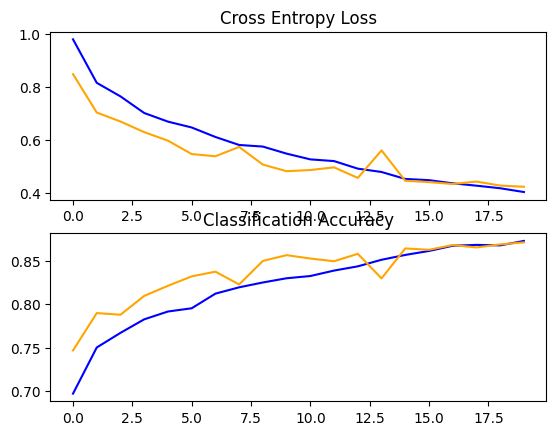

In [12]:
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

50/50 [==============================] - 19s 375ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
                       precision    recall  f1-score   support

         Aarons beard       0.79      0.88      0.83       150
    Anemone_coronaria       0.93      0.86      0.89       150
     Anemone_hepatica       0.88      0.89      0.88       150
   Anemone_hupehensis       0.88      0.86      0.87       150
     Anemone_nemorosa       0.86      0.82      0.84       150
Anemone_ranunculoides       0.83      0.85      0.84       150
   Anthericum_liliago       0.97      0.80      0.88       150
    Barbarea_vulgaris       0.92      0.79      0.85       150
           Bee orchid       0.95      0.90      0.92       150
   Cirsium_eriophorum       0.88      0.91      0.89       150
     English lavender       0.93      0.85      0.89       150
        Field pumpkin       0.85      0.86      0.85       150
     Lactuca_perennis       0.86      0.87      0.87     

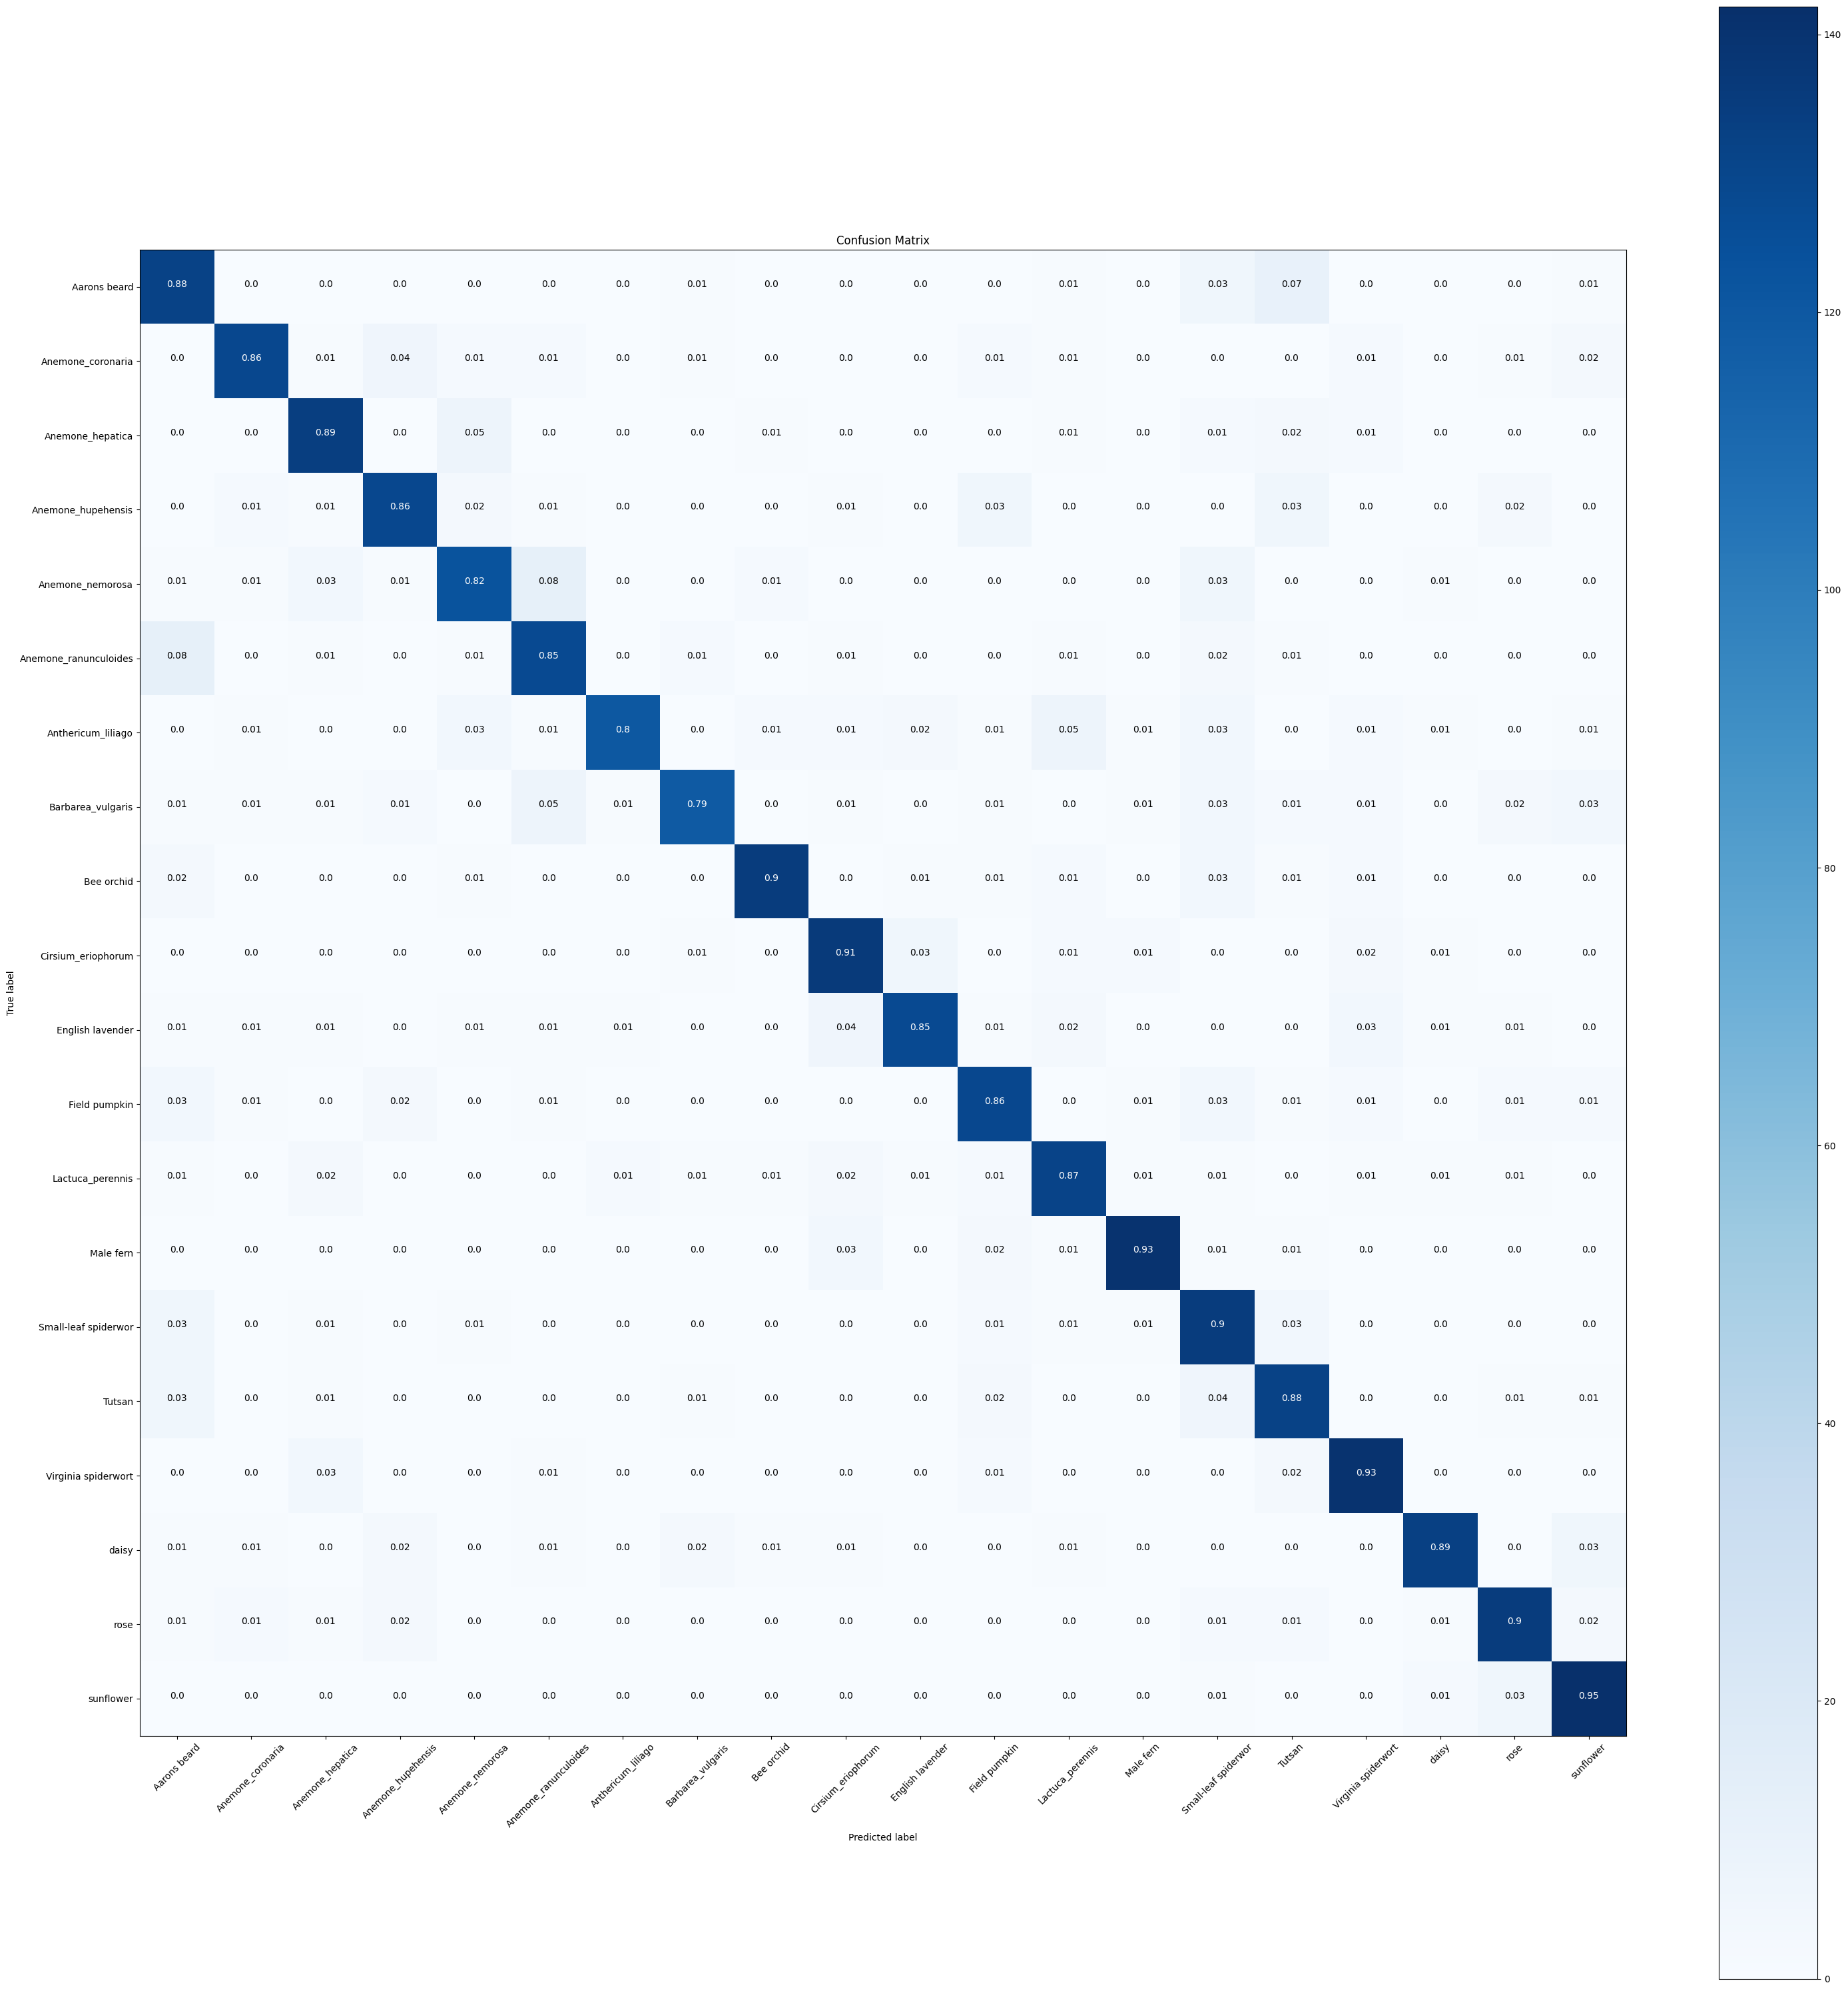

In [14]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(30,30))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in generator_train.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = transfer_model.predict(generator_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(generator_test.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(generator_test.classes, y_pred, target_names=target_names))

In [ ]:
transfer_model.save('finetuneeee_revised.h5')

In [ ]:
!cp transferc.h5 '/content/drive/MyDrive/'